## PricingTest
### Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

### Challenge Description
Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. 

In the experiment, 66\% of the users have seen the old price (39), while a random sample of 33\% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:
1. Should the company sell its software for 39 or 59?
2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
3. [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

### Data
The two tables are:
 1. "test_results" - data about the test
 2. "user_table" - Information about the user

## Data exploration

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

In [3]:
test = pd.read_csv('test_results.csv', parse_dates=['timestamp'])
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [20]:
# Merge test with user 
data = pd.merge(test,user,how='left',on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


Sanity check about data:

In [21]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [22]:
# only keep the valid data
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [23]:
# create new column called `revenue`
data['revenue'] = data['converted'] * data['price']

In [24]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

In [25]:
# Check randominess
data_source = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
data_source

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


In [26]:
data_device = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
data_device

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


In [27]:
data_os = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
data_os

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


In [28]:
# check the conversion rate for A/B test
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [29]:
# check the revenue for A/B test
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


## hypothesis test about AB test on revenue
Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue

Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [33]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


We can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

## Suggest on increase conversion rate

### Source

In [41]:
conversion_source = data[['source','converted']].groupby('source').mean().sort_values(by='converted',ascending=False).reset_index()
conversion_source

,source,converted
0,friend_referral,0.038688
1,seo-bing,0.023787
2,ads-google,0.021502
3,ads_facebook,0.021198
4,seo-google,0.016978
5,seo-yahoo,0.016226
6,seo_facebook,0.016051
7,seo-other,0.015686
8,ads-yahoo,0.014793
9,ads_other,0.014350


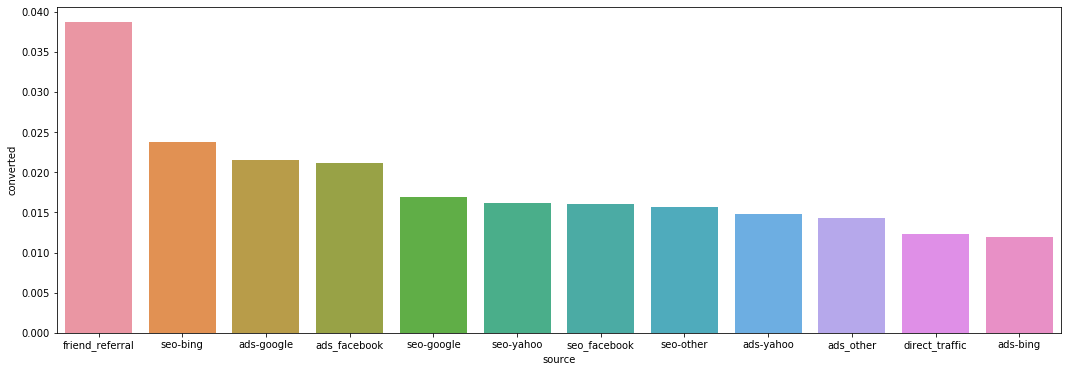

In [43]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='source', y='converted', data=conversion_source, ax=ax)
plt.show()

###  Device

In [44]:
conversion_device = data[['device','converted']].groupby('device').mean().sort_values(by='converted',ascending=False).reset_index()
conversion_device

,device,converted
0,mobile,0.018554
1,web,0.018023


### Operative System

In [45]:
conversion_os = data[['operative_system','converted']].groupby('operative_system').mean().sort_values(by='converted',ascending=False).reset_index()
conversion_os

,operative_system,converted
0,mac,0.023987
1,iOS,0.022328
2,windows,0.016966
3,android,0.014919
4,other,0.012981
5,linux,0.008232


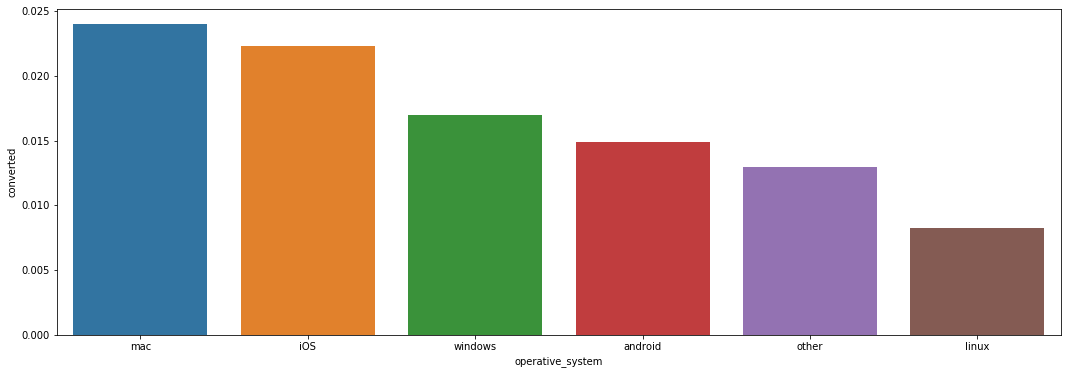

In [46]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='operative_system', y='converted', data=conversion_os, ax=ax)
plt.show()

## Actionable Insights

From the data, we can see Friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors

Some actionable insights:
1. Lauch special marketing program targeted to Apple users (MAC or iOS users)
2. Run some program which rewards users which can invite their friends to use our software
3. Linux users do not like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?